In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
from PIL import Image
import random

In [2]:
train_dir= r'D:\Bangkit 2023\CAPSTONE\kambingseimbang\train'
test_dir= r'D:\Bangkit 2023\CAPSTONE\kambingseimbang\test'

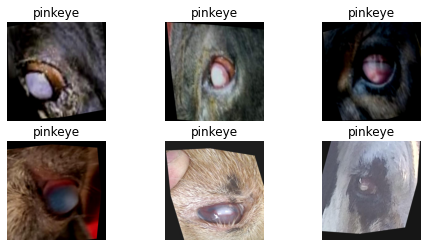

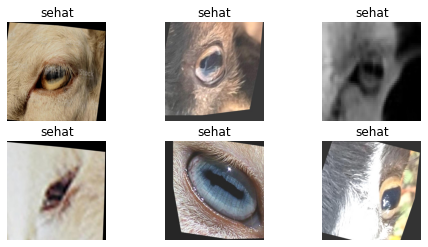

In [3]:
# list nama kelas
class_name = 'pinkeye'
class_name2 = 'sehat'

# list path gambar pada kelas yang dipilih
image_paths = os.listdir(os.path.join(train_dir, class_name))
image_paths2 = os.listdir(os.path.join(train_dir, class_name2))

# memilih 6 gambar secara acak dari kelas yang dipilih
image_paths = random.sample(image_paths, 6)
image_paths2 = random.sample(image_paths2, 6)

# menampilkan 6 gambar dari kelas yang dipilih
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name, image_paths[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name2, image_paths2[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name2}")
    ax.axis('off')
plt.show()

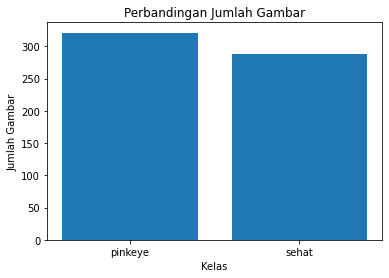

jumlah gambar sapi pinkeye =  321
jumlah gambar sapi sehat =  288


In [4]:
class_names = ['pinkeye', 'sehat']

# menghitung jumlah gambar pada setiap kelas
num_images = []
for class_name in class_names:
    num_images.append(len(os.listdir(os.path.join(train_dir, class_name))))

# menampilkan grafik perbandingan jumlah gambar pada dua kelas
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_names, num_images)
ax.set_title('Perbandingan Jumlah Gambar')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
plt.show()
print('jumlah gambar sapi pinkeye = ',num_images[0])
print('jumlah gambar sapi sehat = ',num_images[1])

In [5]:
# ukuran gambar dan batch nantinya
image_size = 224
batch_size = 32

In [6]:
# augmentasi data train
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=24,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.2,
                                   horizontal_flip=False)

# yang tes cmn rescale aja
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# mempersiapkan data di preprosesing untuk train dan tes nantinya
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 609 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


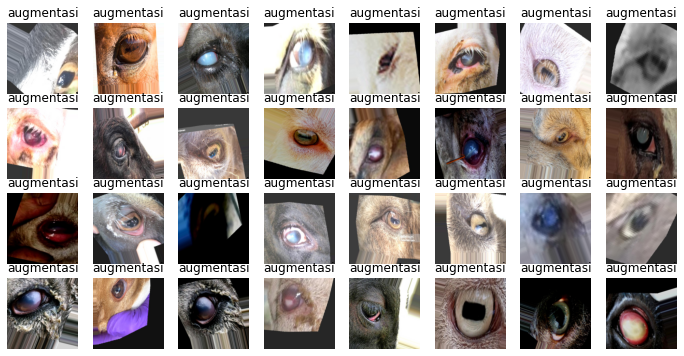

Jumlah gambar hasil augmentasi: 640


In [8]:
augmented_images, _ = train_generator.next()

# memvisualisasikan gambar setelah augmentasi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title('augmentasi')
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.show()
num_augmented_images = len(train_generator)* batch_size
print("Jumlah gambar hasil augmentasi:", num_augmented_images)

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [13]:
num_epochs = 2
import math
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / batch_size) 
)

# i smell overfit...

Epoch 1/2
19/19 [==============================] - 20s 905ms/step - loss: 0.5728 - accuracy: 0.6984 - val_loss: 0.5204 - val_accuracy: 0.7143
Epoch 2/2
19/19 [==============================] - 16s 839ms/step - loss: 0.2906 - accuracy: 0.8873 - val_loss: 0.1363 - val_accuracy: 1.0000


In [14]:
test_loss, test_acc = model.evaluate(validation_generator)
print('akurasi:', test_acc)
#ceto ini overfit wkwk

1/1 [==============================] - 0s 377ms/step - loss: 0.1363 - accuracy: 1.0000
akurasi: 1.0


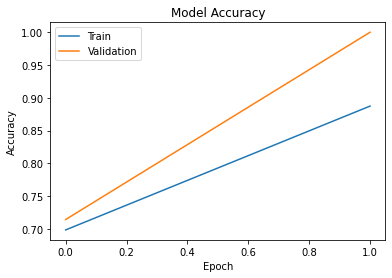

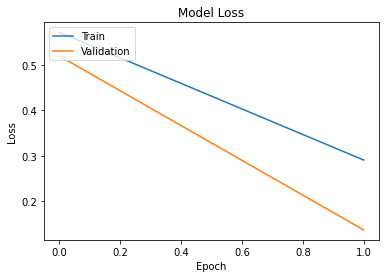

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 380ms/step


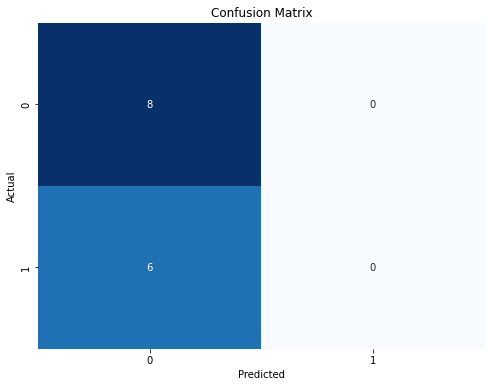

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

validation_generator.reset()
y_pred = model.predict(validation_generator, steps=math.ceil(validation_generator.samples / batch_size))
y_pred = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 1s 782ms/step


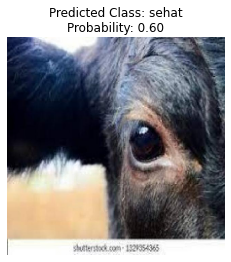

In [16]:
import matplotlib.pyplot as plt

# ambil dan prepros
test_image_path = r'D:\Bangkit 2023\CAPSTONE\sapires\test\sehat\bmbm__jpg.rf.d751e9e0eb8ecc3ac0abcf9f245852f2.jpg'
test_image = image.load_img(test_image_path, target_size=(image_size, image_size))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0 

# Memprediksi
predictions = model.predict(test_image)

# probability
predicted_class = "pinkeye" if predictions[0][0] < 0.5 else "sehat" 
probability = predictions[0][0]

# tampil
plt.imshow(test_image[0])
plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
plt.axis('off')
plt.show()


In [17]:
# model.save('model/sapifitmobilenet1.h5')